# PSI3471 - Aula de Exercícios 07

# CNN com PyTorch

Segue a implementação de uma rede CNN para resolver o problema de classificação de imagens de dígitos numéricos manuscritos do banco de dados [MNIST](https://en.wikipedia.org/wiki/MNIST_database).

<div class="alert alert-block alert-success">
Execute o código e verifique os resultados. Depois, modifique os hiperparâmetros e veja o efeito na acurácia.
</div>

Iniciando com a importação da bibliotecas:

In [ ]:
import numpy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torchvision import datasets, transforms

Ajustando o valor dos hiperparâmetros:

In [ ]:
# Ajuste de hiperparâmetros

# passo de adaptação
eta = 0.01

# Tamanho do mini-batch
Nb = 64

# Tamanho do mini-batch usado no teste
Nb_test = 1000

# Número de épocas
Ne = 1

O PyTorch tem algumas rotinas para carregar bancos de dados clássicos. Vamos usar essas rotinas para carregar o MNIST. Com o código abaixo, os dados vão ser obtidos da internet e gravados no local indicado por `dir_data`, em uma pasta chamada `data`.

Além disso, vamos criar dois objetos `DataLoader`, para treinamento e teste, que vão se encarregar de ler os dados em partes e misturá-los:

In [ ]:
dir_data = "~/temp"

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        dir_data,
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor()]
        ),
    ),
    batch_size=Nb,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        dir_data,
        train=False,
        transform=transforms.Compose(
            [transforms.ToTensor()]
        ),
    ),
    batch_size=Nb_test,
    shuffle=True,
)

Vale notar alguns detalhes sobre o código anterior:

 - o `DataLoader` de treinamento é criado com `train=True` e o de teste, com `train=False`, o que garante que não haja dados em comum entre os dois conjuntos;
 - É feita a configuração de uma transformação de dados ao carregá-los. Para isso, é criado um objeto do tipo `transforms.Compose`, que permite encadear uma série de transformações a serem aplicadas às imagens, durante o carregamento. Nesse caso, a transformação tem uma única etapa que consistem em converter os valores obtidos para um tensor do PyTorch.

Podemos mostrar algumas imagens do dataset usando o DataLoader que criamos:

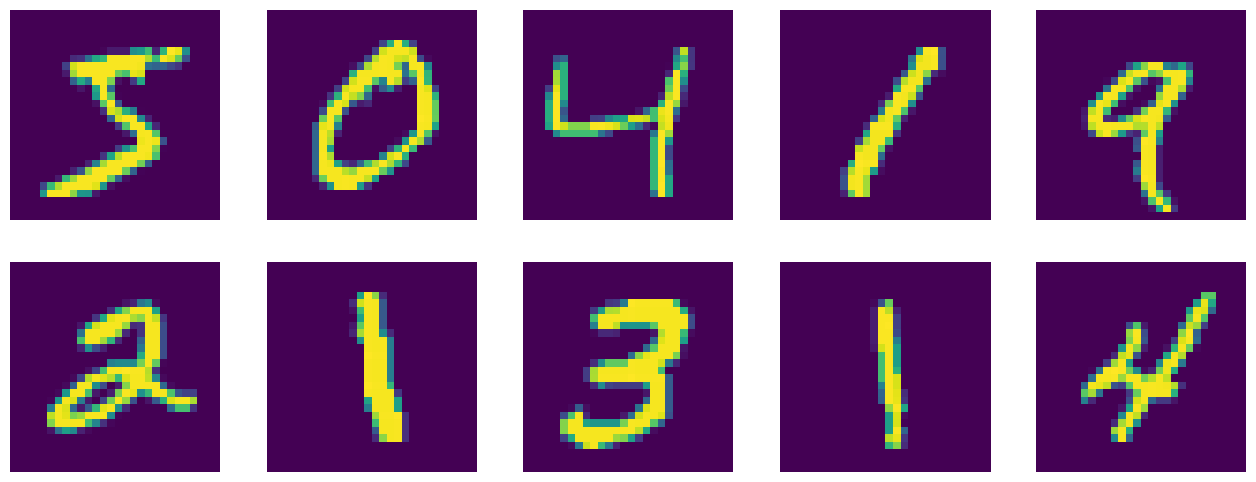

In [ ]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

O modelo é definido por meio de uma classe que herda de `nn.Module`:

In [ ]:
class Model(nn.Module):
    def __init__(self):
        # Necessário chamar __init__() da classe mãe
        super().__init__()

        # Camada convolucional, seguida de ReLU e Pooling
        # Entra uma imagem 28x28. Com filtro 5x5, padding de 2
        # e stride 1, a saída também tem 28x28. Após o pooling,
        # a saída fica com 14x14. A entrada tem 1 canal e a
        # saída tem 16.
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        # Camada convolucional
        # Entrada 14x14, saída 7x7 após o pooling.
        # 16 canais de entrada e 32 de saída.
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Camada totalmente conectada
        # Na entrada, há 32 canais de 7x7 elementos
        # e a saída tem 10 neurônios.
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        # Aplica primeira camada convolucional
        x = self.conv1(x)

        # Aplica segunda camada convolucional
        x = self.conv2(x)

        # Transforma os tensores 32x7x7 em
        # vetores para serem usados na entrada da
        # camada totalmente conectada. Vale notar
        # que a primeira dimensão dos tensores de
        # dados é usada para representar os diversos
        # elementos de um batch, por isso permanece
        # inalterada.
        x = x.view(x.size(0), -1)

        # Calcula a saída e retorna
        output = self.out(x)
        return output

Instanciando o modelo e definindo a função custo e o otimizador:

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instanciando modelo
model = Model().to(device)

# Função custo para treinamento
loss_function = nn.CrossEntropyLoss()

# Otimizador
optimizer = torch.optim.Adam(model.parameters(), lr = eta)

Vale notar que a função custo `CrossEntropyLoss` espera comparar um vetor de $C$ posições com um número de $0$ a $C-1$, conforme descrito na [documentação](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Além disso, é esperado que os elementos do vetor representem a *evidência*, ou seja os valores chamados de *logits*, que não são normalizados e podem valer de $-\infty$ a $\infty$. Por isso, na saída da rede, não é usada a função *Softmax*.

Definindo o *loop* de treinamento:

Época: 0 [0/60000 (0%)]	Loss: 2.313829
Época: 0 [6400/60000 (11%)]	Loss: 0.380088
Época: 0 [12800/60000 (21%)]	Loss: 0.037174
Época: 0 [19200/60000 (32%)]	Loss: 0.105271
Época: 0 [25600/60000 (43%)]	Loss: 0.003689
Época: 0 [32000/60000 (53%)]	Loss: 0.026571
Época: 0 [38400/60000 (64%)]	Loss: 0.131071
Época: 0 [44800/60000 (75%)]	Loss: 0.062415
Época: 0 [51200/60000 (85%)]	Loss: 0.177684
Época: 0 [57600/60000 (96%)]	Loss: 0.050025


Text(0, 0.5, 'Loss')

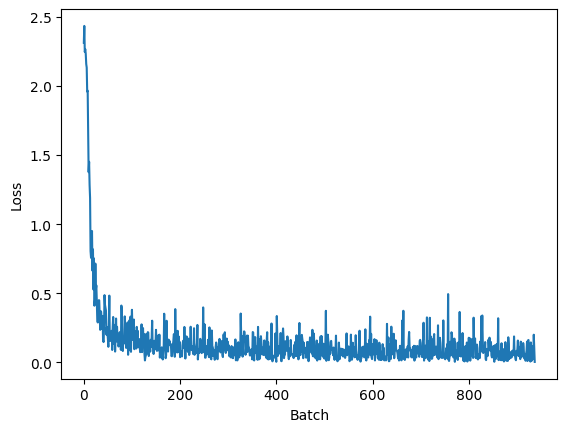

In [ ]:
# Lista usada para guardar o valor da função custo ao longo das iterações
losses = []

# Loop das épocas
for epoch in range(Ne):
    # Loop dos mini batches
    for n, (X, d) in enumerate(train_loader):
        # Envia os dados para a GPU, caso ela exista
        X = X.to(device=device)
        d = d.to(device=device)

        # Ajuste de dimensões
        # (elementos do mini batch x 1 canal x 28 x 28)
        X = X.view(-1, 1, 28, 28)

        # Coloca o modelo em modo treinamento
        model.train()

        # Zera informações de gradientes
        model.zero_grad()

        # Calcula a saída
        y = model(X)

        # Calcula o valor da função custo
        loss = loss_function(y, d)

        # Calcula os gradientes
        loss.backward()

        # Atualiza os pesos do modelo
        optimizer.step()

        # Armazena o valor da função custo
        losses.append(loss.item())

        # Mostra o valor da função custo a cada 100 iterações
        if n % 100 == 0:
            N_all = len(train_loader.dataset)
            n_ex = n * len(X)
            p = 100. * n / len(train_loader)
            print(
                f"Época: {epoch} [{n_ex}/{N_all} ({p:.0f}%)]\tLoss: {loss:.6f}"
            )

plt.figure()
plt.plot(losses)
plt.xlabel("Batch")
plt.ylabel("Loss")

Avaliando modelo com os dados de teste:

In [ ]:
# Variável usada para contabilizar o número de acertos
correct = 0

# Loop dos mini batches
for n, (X, d) in enumerate(test_loader):
    # Envia os dados para a GPU, caso ela exista
    X = X.to(device=device)
    d = d.to(device=device)

    # Ajuste de dimensões
    X = X.view(-1, 1, 28, 28)

    # Coloca o modelo em modo de inferência
    model.eval()

    # Calcula a saída
    y = model(X)

    # Cálculo do número de acertos:
    # 1) Obtém o índice do elemento máximo para cada exemplo do minibatch
    pred = torch.max(y, 1, keepdim=True)[1]
    # 2) Conta o número de acertos e acumula na variável correct
    # pred.eq(d.view_as(pred)) é um tensor booleano. Dessa forma, o número de
    # acertos é obtido somando seus elementos. Valores True são tratados como 1.
    correct += pred.eq(d.view_as(pred)).cpu().sum().item()

# Mostra o desempenho obtido no teste
accuracy = 100. * correct / len(test_loader.dataset)
print(f"Acurácia: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)")

Acurácia: 9758/10000 (98%)
